In [ ]:
!pip install diffusers
!pip install transformers scipy ftfy accelerate
!pip install "ipywidgets>=7,<8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.8/851.8 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.3 MB/s eta 0:00:00


In [ ]:
import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
from google.colab import output

device = 'cuda'

output.enable_custom_widget_manager()
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


**Sử dụng model có sẵn, đã được train từ trước**

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", revision='fp16',
    torch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to(device)

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
from diffusers import DPMSolverMultistepScheduler

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

  0%|          | 0/25 [00:00<?, ?it/s]

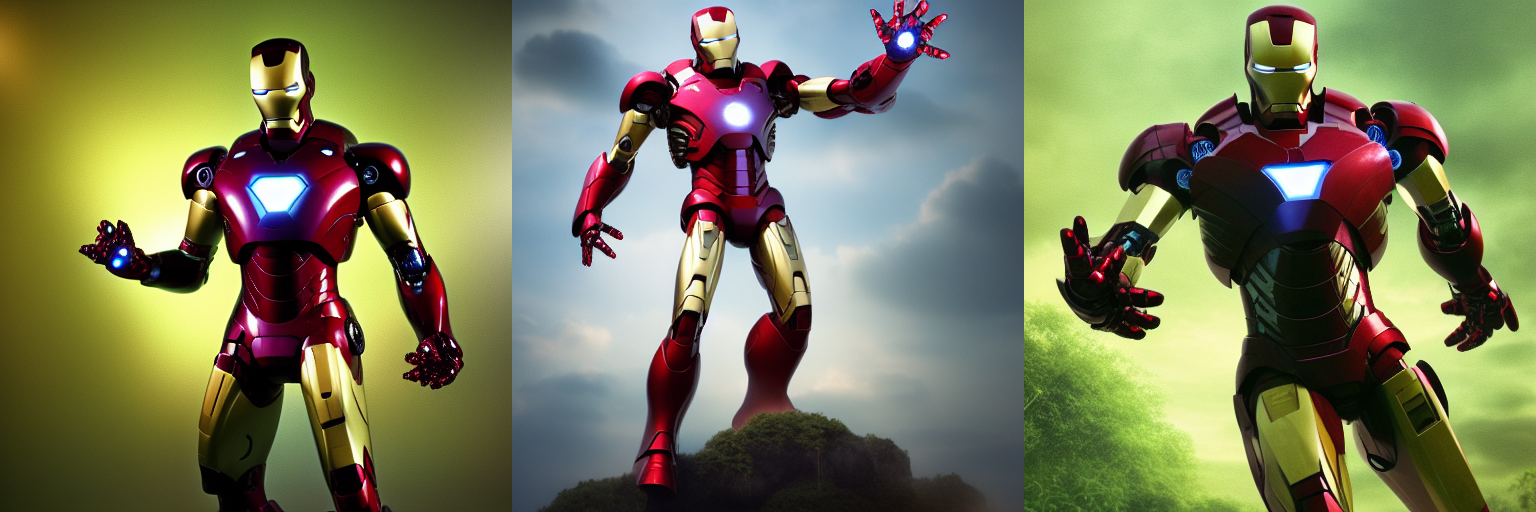

In [ ]:
#tạo 3 ảnh
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid
n_images = 3
prompts = ['Iron Man, (Arnold Tsang, Toru Nakayama), Masterpiece, Studio Quality, 6k , toa, toaair, 1boy, glowing, axe, mecha, science_fiction, solo, weapon, jungle , green_background, nature, outdoors, solo, tree, weapon, mask, dynamic lighting, detailed shading, digital texture painting'] * n_images
torch.cuda.empty_cache()
with autocast(device):
  images = pipe(prompts, num_inference_steps=25).images
image_grid(images, rows=1, cols=3)

**CUSTOM PIPELINE**

In [ ]:
# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained(
    'runwayml/stable-diffusion-v1-5', subfolder='vae', use_auth_token=True)
vae = vae.to(device)

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = text_encoder.to(device)

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained(
    'runwayml/stable-diffusion-v1-5', subfolder='unet', use_auth_token=True)
unet = unet.to(device)

# 4. Create a scheduler for inference
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.15.layer_norm2.bias', 'vision_model.encoder.layers.12.self_attn.v_proj.weight', 'vision_model.encoder.layers.20.self_attn.out_proj.weight', 'vision_model.encoder.layers.17.mlp.fc2.bias', 'vision_model.encoder.layers.23.layer_norm2.weight', 'vision_model.encoder.layers.1.self_attn.k_proj.weight', 'vision_model.encoder.layers.12.layer_norm2.weight', 'vision_model.encoder.layers.5.self_attn.v_proj.bias', 'vision_model.encoder.layers.5.self_attn.out_proj.weight', 'vision_model.encoder.layers.20.mlp.fc1.weight', 'vision_model.encoder.layers.23.layer_norm1.bias', 'vision_model.encoder.layers.16.self_attn.v_proj.bias', 'vision_model.encoder.layers.20.layer_norm2.weight', 'vision_model.encoder.layers.17.self_attn.v_proj.bias', 'vision_model.embeddings.position_ids', 'vision_model.encoder.layers.1.layer_norm1.bias', 'vision_model.encoder.layers.17.ml

In [ ]:
def get_text_embeds(prompt):
  # Tokenize text and get embeddings
  text_input = tokenizer(
      prompt, padding='max_length', max_length=tokenizer.model_max_length,
      truncation=True, return_tensors='pt')
  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

  # Do the same for unconditional embeddings
  uncond_input = tokenizer(
      [''] * len(prompt), padding='max_length',
      max_length=tokenizer.model_max_length, return_tensors='pt')
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

  # Cat for final embeddings
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  return text_embeddings

test_embeds = get_text_embeds(['Vietnam supervillain, realistic, masterpiece, high quality, '])
print(test_embeds)
print(test_embeds.shape)

tensor([[[-3.8838e-01,  2.2944e-02, -5.2197e-02,  ..., -4.8988e-01,
          -3.0660e-01,  6.7454e-02],
         [-3.7112e-01, -1.4497e+00, -3.4011e-01,  ...,  9.4886e-01,
           1.8672e-01, -1.1034e+00],
         [-5.1074e-01, -1.4629e+00, -2.9256e-01,  ...,  1.0419e+00,
           7.0059e-02, -1.0284e+00],
         ...,
         [ 5.0060e-01, -9.5523e-01, -6.6103e-01,  ...,  1.6013e+00,
          -1.0622e+00, -2.1908e-01],
         [ 4.9881e-01, -9.4509e-01, -6.6561e-01,  ...,  1.6467e+00,
          -1.0858e+00, -2.0878e-01],
         [ 4.9235e-01, -8.1244e-01, -4.9119e-01,  ...,  1.6108e+00,
          -1.0174e+00, -2.4838e-01]],

        [[-3.8838e-01,  2.2944e-02, -5.2197e-02,  ..., -4.8988e-01,
          -3.0660e-01,  6.7454e-02],
         [-8.3763e-01, -3.1123e-01,  1.3500e-01,  ..., -8.2946e-02,
           3.7587e-01, -9.1954e-01],
         [-2.9241e-01,  1.9973e-02, -3.9130e-01,  ..., -1.9674e+00,
          -7.3359e-04, -1.2408e+00],
         ...,
         [-1.0656e+00,  5

In [ ]:
def produce_latents(text_embeddings, height=512, width=512,
                    num_inference_steps=150, guidance_scale=7.5, latents=None):
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \
                           height // 8, width // 8))
  latents = latents.to(device)

  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.init_noise_sigma

  with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, t, latents)['prev_sample']

  return latents

test_latents = produce_latents(test_embeds)
print(test_latents)
print(test_latents.shape)

/usr/local/lib/python3.9/dist-packages/diffusers/models/unet_2d_condition.py:452: FutureWarning: Accessing `in_channels` directly via unet.in_channels is deprecated. Please use `unet.config.in_channels` instead
  deprecate(


0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/diffusers/schedulers/scheduling_lms_discrete.py:244: UserWarning: The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
  warnings.warn(


tensor([[[[ 0.9634,  0.4488, -0.0484,  ...,  0.2785, -1.0058, -0.2623],
          [ 1.0599, -0.5529, -1.2130,  ..., -1.4985, -0.3790, -1.4146],
          [ 0.1666, -0.3084, -0.6534,  ..., -0.4090, -1.3402, -1.1183],
          ...,
          [ 1.2753,  1.4609,  0.2343,  ...,  0.6169,  0.0805,  0.4786],
          [ 1.4445, -0.0912,  1.0519,  ...,  0.1183,  1.1516,  0.6640],
          [ 0.6997,  1.4315,  1.1967,  ...,  0.9618, -0.0086,  0.5880]],

         [[-1.7435, -1.1066, -1.9751,  ..., -1.2793, -1.2248, -0.5364],
          [-1.8201, -1.5919, -0.8494,  ..., -0.4130, -0.0199, -0.3844],
          [-2.2208, -0.1340, -1.5658,  ..., -0.7985, -0.0052, -1.3224],
          ...,
          [-0.3984,  1.7995,  1.4494,  ...,  0.5182,  0.4743,  0.8044],
          [ 1.3832,  0.1166,  1.0547,  ...,  0.2126,  0.2545,  0.4823],
          [ 0.7965, -0.9532,  0.6562,  ...,  0.5681,  0.1219,  0.2329]],

         [[ 0.8153,  0.6991,  0.4316,  ..., -0.4575,  0.8184,  0.4291],
          [ 1.3222,  0.9835, -

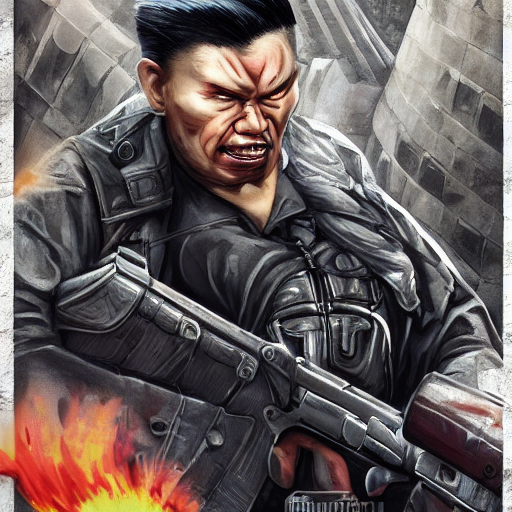

In [ ]:
def decode_img_latents(latents):
  latents = 1 / 0.18215 * latents

  with torch.no_grad():
    image = vae.decode(latents).sample

  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

imgs = decode_img_latents(test_latents)
imgs[0]